# Mr Haulage - Fleet Analysis - Exploratory Data Analysis
## Author: Lottie Jane Pollard

*"Data matters. Data is the way we measure progress." - Hilary Mason*
*"Without data, you're just another person with an opinion." - W. Edwards Deming*

----------------------------------


<img src="/Users/lottiejanepollare/Library/Mobile Documents/com~apple~CloudDocs/CV, Profiles, Interviews & Job Applications/applications/techmodal_analyst_data_engineer/20230825_Analyst_case_study_submission_Lottie_Jane_Pollard/images/logos/techmodal/techmodal_opp_found_logo.png" alt="techmodal_logo" width="350"/>

In [1]:
# libraries to import

import pandas as pd
import math
import matplotlib as plt
from prophet import Prophet


Importing plotly failed. Interactive plots will not work.


### Import the clean dataset, load in the metadata, configure the display & have a look at the dataset

In [2]:
# import the clean dataset
mr_haulage_df = pd.read_csv(
    '/Users/lottiejanepollare/Library/Mobile Documents/com~apple~CloudDocs/CV, Profiles, Interviews & Job Applications/applications/techmodal_analyst_data_engineer/20230825_Analyst_case_study_submission_Lottie_Jane_Pollard/datasets/cleansed_mr_haulage_order_details.csv')

# add data types in from previous metadata
metadata_df = pd.read_excel('/Users/lottiejanepollare/Library/Mobile Documents/com~apple~CloudDocs/CV, Profiles, Interviews & Job Applications/applications/techmodal_analyst_data_engineer/20230825_Analyst_case_study_submission_Lottie_Jane_Pollard/datasets/metadata.xlsx')
metadata_dict = metadata_df.set_index('column_name')['datatype'].to_dict()
mr_haulage_df = mr_haulage_df.astype(metadata_dict)

# configure display settings: display all columns regardless of df width, disable wrapping columns to display entire field, no truncating columns, display an English date format
pd.set_option('display.max.columns', None, 'display.width', None, 'display.max.colwidth', None, 'display.date_dayfirst', True, 'display.float_format', '{:.2f}'.format)
# this should update the date format displayed for the whole notebook, but it isn't & I'm not sure why - maybe as I'm in Pycharm IDE note JupyterNotebooks itself

# let's see what we're working with
mr_haulage_df.head(10)

,order_id,customer_id,order_date,order_time,order_revenue,item_serial,box_type,delivery_region,distance_(miles),order_week,order_month,order_year,financial_quarter
0,1097342,733603,2021-08-22,00:14:00,20.00,30351,small,south_east,70,33,August,2021,Q3
1,1097343,405061,2021-08-22,07:08:00,20.00,17634,small,greater_london,32,33,August,2021,Q3
2,1097344,842139,2021-08-22,10:15:00,20.00,25598,small,south_west,190,33,August,2021,Q3
3,1097345,211806,2021-08-22,17:05:00,20.00,10104,small,south_west,85,33,August,2021,Q3
4,1097346,103222,2021-08-22,23:48:00,20.00,3252,small,greater_london,43,33,August,2021,Q3
5,1097347,603400,2021-08-22,23:57:00,20.00,62831,small,greater_london,33,33,August,2021,Q3
6,1097354,862722,2021-08-23,21:56:00,20.00,32892,small,south_wales,171,34,August,2021,Q3
7,1097353,697945,2021-08-23,20:34:00,20.00,23747,small,south_east,67,34,August,2021,Q3
8,1097352,870782,2021-08-23,19:03:00,20.00,20624,small,south_east,72,34,August,2021,Q3
9,1097350,239710,2021-08-23,11:49:00,100.00,99590,large,north_east,210,34,August,2021,Q3


In [3]:
# check metadata & datatypes have loaded correctly
mr_haulage_df.dtypes

order_id                      int64
customer_id                   int64
order_date           datetime64[ns]
order_time                   object
order_revenue               float64
item_serial                   int64
box_type                   category
delivery_region            category
distance_(miles)              int64
order_week                   UInt32
order_month                  object
order_year                    int32
financial_quarter            object
dtype: object

## Let's start to inspect the relationship between the data & derive some insights


NB: the data is lacking in integer types to perform any kind of significant heatmap to start with, so I won't be creating on for this dataset

### Let's have a look at the trend of orders over the span of the dataset

In [4]:
# copy the dataframe
monthly_order_pattern = mr_haulage_df.copy()

# order_date as index & use resample() to aggregate data by month, so we only have one marker per month & one tick per month
monthly_order_pattern.set_index('order_date', inplace=True)
monthly_order_pattern = monthly_order_pattern.resample('M').size().reset_index(name='number_of_orders')

# format the dates for readability
monthly_order_pattern['formatted_date'] = monthly_order_pattern['order_date'].dt.strftime('%b_%y')

monthly_order_pattern

,order_date,number_of_orders,formatted_date
0,2021-08-31,65,Aug_21
1,2021-09-30,80,Sep_21
2,2021-10-31,95,Oct_21
3,2021-11-30,79,Nov_21
4,2021-12-31,58,Dec_21
5,2022-01-31,59,Jan_22
6,2022-02-28,55,Feb_22
7,2022-03-31,127,Mar_22
8,2022-04-30,107,Apr_22
9,2022-05-31,121,May_22


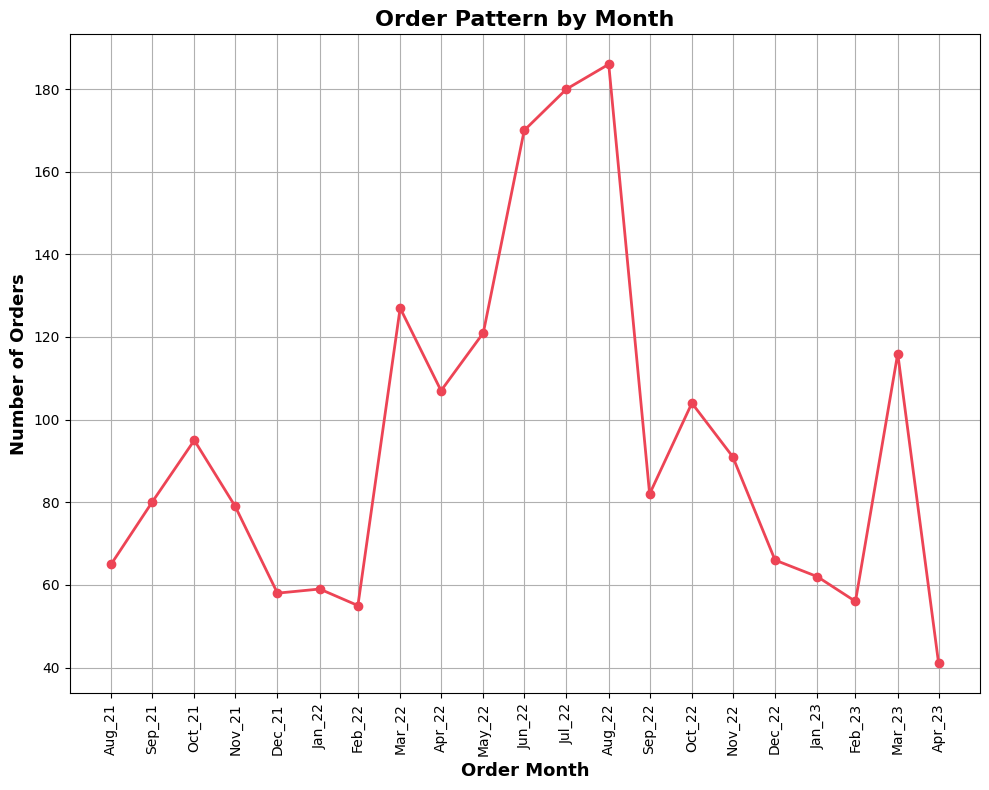

In [5]:
# let's visualise this

plt.figure(figsize=(10, 8))

plt.plot(monthly_order_pattern['order_date'], monthly_order_pattern['number_of_orders'],
         marker='o', linestyle='-', linewidth=2, color='#ED4455')

plt.grid(True)
plt.title('Order Pattern by Month', fontsize=16, fontweight='bold', ha='center', y=1.0)
plt.xlabel('Order Month', fontweight='bold', fontsize=13)
plt.ylabel('Number of Orders', fontweight='bold', fontsize=13)

plt.xticks(monthly_order_pattern['order_date'], monthly_order_pattern['formatted_date'], rotation='vertical')

plt.tight_layout()
plt.savefig('/Users/lottiejanepollare/Library/Mobile Documents/com~apple~CloudDocs/CV, Profiles, Interviews & Job Applications/applications/techmodal_analyst_data_engineer/20230825_Analyst_case_study_submission_Lottie_Jane_Pollard/images/data_visualisations/fig1_order_pattern_by_month.png')

plt.show()

### The plot reveals several interesting trends and patterns in the data:

* Seasonal Trends: There seems to be some seasonality in the data. Specifically, orders tend to peak around mid-year (June to August) and dip during the end and beginning of the year.

* Growth Pattern: From March 2022 to August 2022, there is a noticeable upward trend, indicating a period of significant growth in the number of orders.

* Inconsistency: After the peak in August 2022, there is a significant drop in September 2022, followed by some fluctuations. This could be indicative of some event or change that affected the number of orders.

* Low Points: The lowest number of orders occurs generally around the end and the beginning of the year, specifically in December and January.

* Recovery in March: After a dip in January and February 2023, the number of orders seems to recover in March 2023, following the general seasonal pattern observed in the previous year.

* Overall Increase: Despite fluctuations, if you look from August 2021 to March 2023, there is a general increase in the number of orders, indicating positive growth.

### Let's look at possible future order volumes using Facebook's open source modelling library Prophet. Prophet uses a 95% confidence interval which means that the model is 95% sure that the predictions will fall within the shaded area on the plot.

I chose to use Prophet as it's relatively easy to use, and it also takes seasonal effects into consideration, which is crucial in this business case.

19:02:12 - cmdstanpy - INFO - Chain [1] start processing
19:02:16 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/nm/6g919fjn6cq_y63lqrsbxjjr0000gn/T/ipykernel_9746/1521909583.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


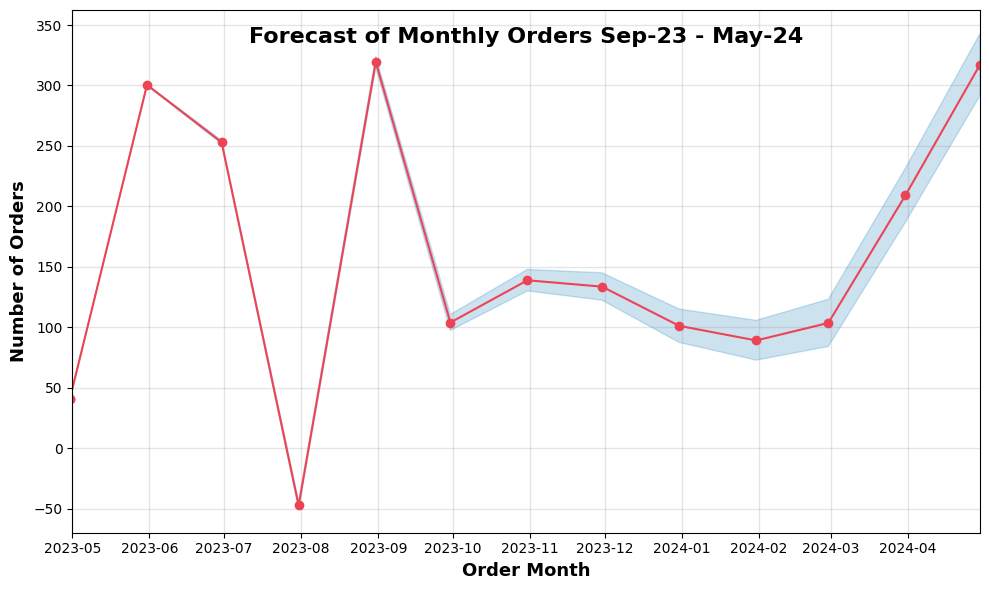

In [6]:
# rename columns to fit the Prophet naming scheme
prophet_df = monthly_order_pattern.rename(columns={'order_date': 'ds', 'number_of_orders': 'y'})

model = Prophet(yearly_seasonality=True)
model.fit(prophet_df)

# create future dataframe over 12 months with monthly frequency
future_dates = model.make_future_dataframe(periods=12, freq='M')

# forecast the order volume
forecast = model.predict(future_dates)

# plot the forecast
fig = model.plot(forecast)

# narrow down the x axis to show a closer look
ax = fig.gca()
ax.set_xlim([pd.to_datetime('2023-05-01'), forecast['ds'].max()])

# editing colour & markers using .line
for line in ax.lines:
    line.set_color('#ED4455')
    line.set_marker('o')

ax.set_title('Forecast of Monthly Orders Sep-23 - May-24', fontsize=16, fontweight='bold', loc='center', y=0.92)
ax.set_xlabel('Order Month', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Orders', fontsize=13, fontweight='bold')

plt.tight_layout()

plt.savefig('/Users/lottiejanepollare/Library/Mobile Documents/com~apple~CloudDocs/CV, Profiles, Interviews & Job Applications/applications/techmodal_analyst_data_engineer/20230825_Analyst_case_study_submission_Lottie_Jane_Pollard/images/data_visualisations/fig2_prophet_forecast_monthly_order_volume_sep23-may24.png')

plt.show()

Mr Haulage can see that the predicted order peak has just been reached. Orders are expected to fall seasonally over the winter months as is usual. However, delightfully, the model has taken the general increase in order numbers & historical positive growth into consideration & can say with 95% confidence that the orders for the Oct 23 - Jan 24 will be reasonably higher than the last two years

### Let's look at the 'distance_(miles)' for each delivery in relation to the 'delivery_region', this will give me an idea of where the main distribution depot is. I can also then use this to look at it in relation to the percentage of order placed in each region.

In [7]:
# calculate the delivery distance per delivery region
avg_distance_per_region = mr_haulage_df.groupby('delivery_region')['distance_(miles)'].mean().reset_index().sort_values(by='distance_(miles)')

print(f"The main distribution depot is most likely to be in {avg_distance_per_region['delivery_region'].iloc[0]} as it's the shortest delivery distance")
print(f"--------------------------------------------------------")
avg_distance_per_region

The main distribution depot is most likely to be in greater_london as it's the shortest delivery distance
--------------------------------------------------------


,delivery_region,distance_(miles)
1,greater_london,26.91
4,south_east,60.23
0,east_midlands,82.70
7,west_midlands,119.23
6,south_west,179.88
5,south_wales,195.53
3,north_wales,213.87
2,north_east,233.84


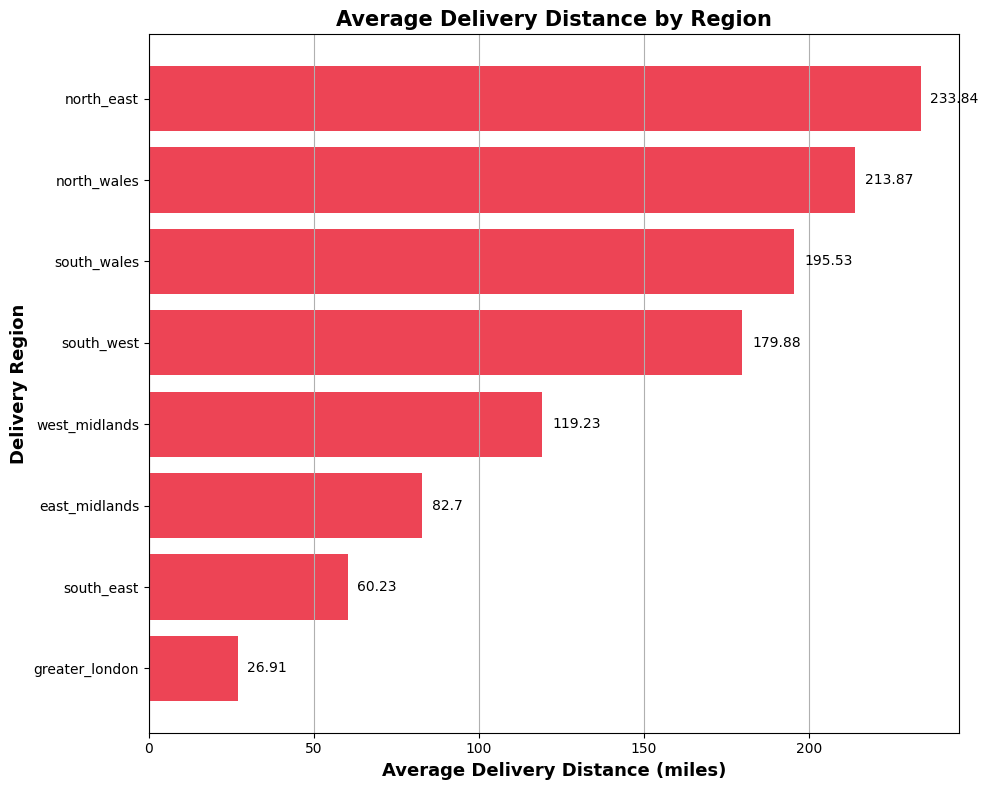

Here we can see that the shortest distance a courier has to travel from it's starting position is an average of 26.91 miles within Greater London


In [8]:
# let's see this as a visualisation

plt.figure(figsize=(10, 8))

plt.barh(avg_distance_per_region['delivery_region'], avg_distance_per_region['distance_(miles)'], color='#ED4455')

plt.title('Average Delivery Distance by Region', fontweight='bold', fontsize=15, loc='center', y=1.0)
plt.xlabel('Average Delivery Distance (miles)', fontweight='bold', fontsize=13)
plt.ylabel('Delivery Region', fontweight='bold', fontsize=13)

# annotate each bar with values
for i, v in enumerate(avg_distance_per_region['distance_(miles)']):
    plt.text(v + 3, i, str(round(v, 2)), va='center', color='black')

plt.grid(axis='x')
plt.tight_layout()
plt.savefig('/Users/lottiejanepollare/Library/Mobile Documents/com~apple~CloudDocs/CV, Profiles, Interviews & Job Applications/applications/techmodal_analyst_data_engineer/20230825_Analyst_case_study_submission_Lottie_Jane_Pollard/images/data_visualisations/fig3_avg_delivery_distance_by_region.png')

plt.show()

print(f"Here we can see that the shortest distance a courier has to travel from it's starting position is an average of 26.91 miles within Greater London")

### let's look at the most popular delivery regions

In [9]:
# count ('order_count') & sort the delivery regions
most_popular_delivery_regions_by_orders = mr_haulage_df.groupby('delivery_region').size().reset_index(name='order_count').sort_values('order_count', ascending=False)

# calculate the total number of orders
total_orders = most_popular_delivery_regions_by_orders['order_count'].sum()

# calculate percentage of orders
most_popular_delivery_regions_by_orders['percentage_of_total_orders'] = (most_popular_delivery_regions_by_orders['order_count'] / total_orders) * 100

most_popular_delivery_regions_by_orders

,delivery_region,order_count,percentage_of_total_orders
1,greater_london,629,31.45
4,south_east,475,23.75
6,south_west,309,15.45
0,east_midlands,199,9.95
5,south_wales,132,6.60
2,north_east,108,5.40
7,west_midlands,96,4.80
3,north_wales,52,2.60


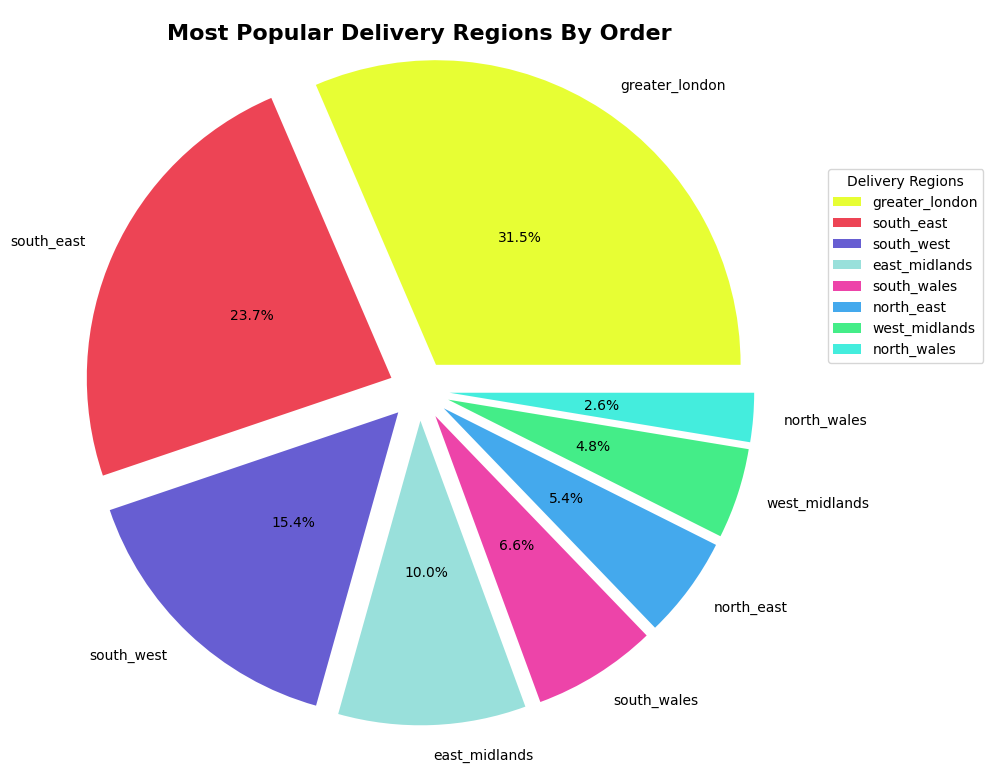

Here we can see that the most popular delivery region is Greater London with 31.5% of orders being delivered here


In [32]:
# let's see this as a visualisation

plt.figure(figsize=(10, 10))

# choose favourite colours
colours = ['#E7FE34', '#ED4455', '#675ED2', '#99E0DB', '#ED44A9', '#44A9ED', '#44ED88', '#44EDDD']

plt.pie(most_popular_delivery_regions_by_orders['percentage_of_total_orders'], labels=most_popular_delivery_regions_by_orders['delivery_region'], colors=colours, autopct='%1.1f%%', pctdistance=0.5,
        explode=[0.1]*len(most_popular_delivery_regions_by_orders))

plt.title('Most Popular Delivery Regions By Order', fontsize=16, fontweight='bold', ha='center', y=0.95)
plt.legend(title='Delivery Regions', loc='upper right', bbox_to_anchor=(1.25, 0.8))

plt.tight_layout()
plt.savefig('/Users/lottiejanepollare/Library/Mobile Documents/com~apple~CloudDocs/CV, Profiles, Interviews & Job Applications/applications/techmodal_analyst_data_engineer/20230825_Analyst_case_study_submission_Lottie_Jane_Pollard/images/data_visualisations/fig4_most_popular_delivery_regions_by_order.png')

plt.show()

print(f"Here we can see that the most popular delivery region is Greater London with 31.5% of orders being delivered here")

### Okay, let's overlay these two visuals to see the correlation between the region with the shortest delivery distance & the most common delivery region

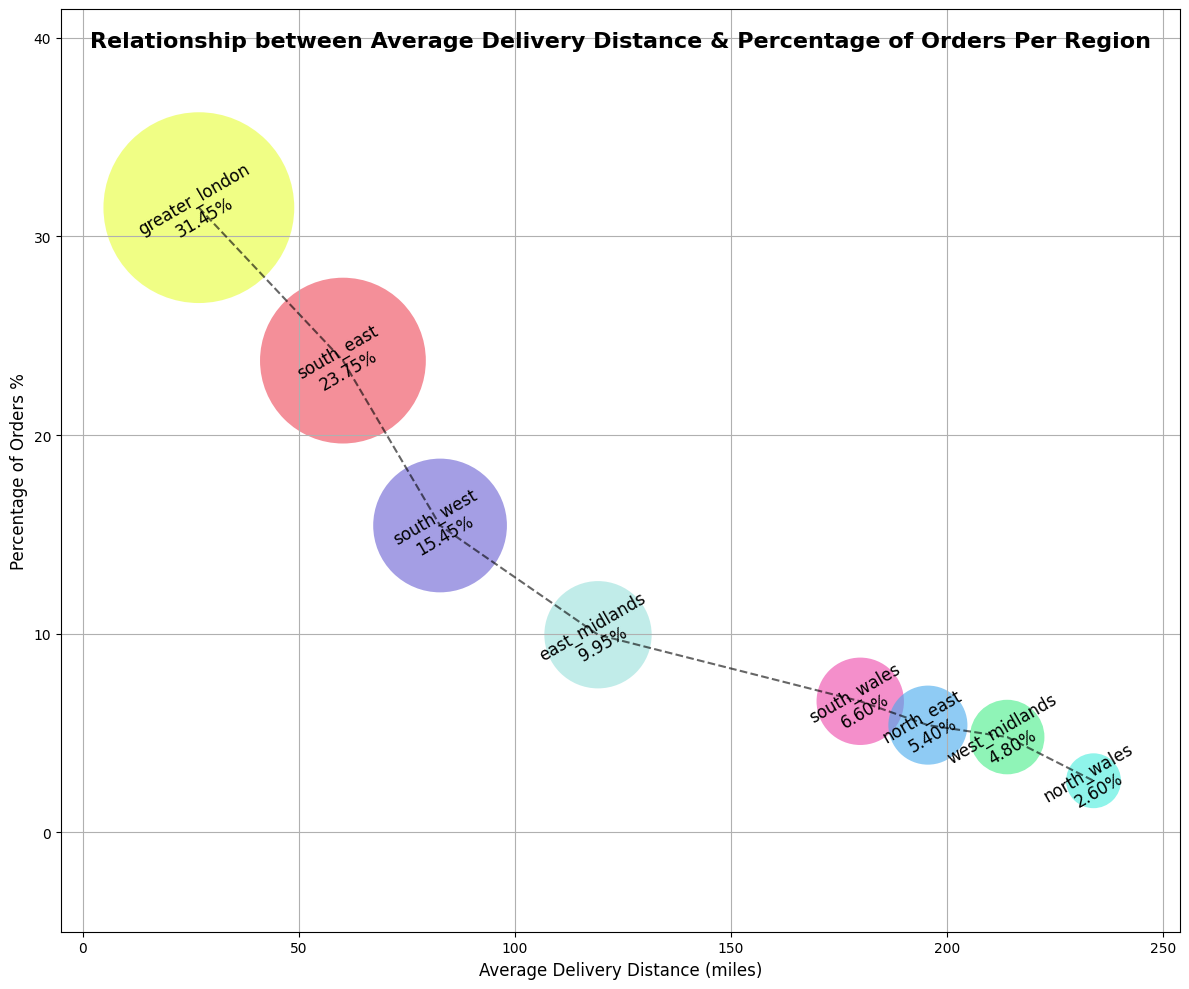

Here we can see that there is a negative correlation between the percentage of orders and the distance travelled to fulfil the order, which indicates that the further away the delivery the less orders we have, conversely, the shorter the distance travelled, the more orders we have.


In [31]:
# let's visualise this
fig, ax = plt.subplots(figsize=(12, 10))

# create bubble chart
scatter = ax.scatter(avg_distance_per_region['distance_(miles)'], most_popular_delivery_regions_by_orders['percentage_of_total_orders'],
                     s=most_popular_delivery_regions_by_orders['percentage_of_total_orders'] * 600,
                     c=colours, alpha=0.6, edgecolors='none', marker='o')

# annotate each bubble
for i, (index, row) in enumerate(most_popular_delivery_regions_by_orders.iterrows()):
    text_label = f"{row['delivery_region']}\n{row['percentage_of_total_orders']:.2f}%"
    plt.text(avg_distance_per_region['distance_(miles)'].iloc[i], row['percentage_of_total_orders'],
             text_label, color='black', ha='center', va='center', fontsize=12, rotation=30)

# connect bubbles
plt.plot(avg_distance_per_region['distance_(miles)'], most_popular_delivery_regions_by_orders['percentage_of_total_orders'], linestyle='--', color='black', alpha=0.6)

# increase axis range to avoid cutting off the bubbles or text
plt.ylim(-5, max(most_popular_delivery_regions_by_orders['percentage_of_total_orders']) + 10)
plt.xlim(-5, max(avg_distance_per_region['distance_(miles)']) + 20)

plt.grid(True)
plt.title('Relationship between Average Delivery Distance & Percentage of Orders Per Region', fontsize=16, fontweight='bold', ha='center', y=0.95)
plt.xlabel('Average Delivery Distance (miles)', fontsize=12)
plt.ylabel('Percentage of Orders %', fontsize=12)


plt.tight_layout()
plt.savefig('/Users/lottiejanepollare/Library/Mobile Documents/com~apple~CloudDocs/CV, Profiles, Interviews & Job Applications/applications/techmodal_analyst_data_engineer/20230825_Analyst_case_study_submission_Lottie_Jane_Pollard/images/data_visualisations/fig5_relationship_between_average_delivery_distance_and_percentage_orders_per_region.png')

plt.show()

print(f"Here we can see that there is a negative correlation between the percentage of orders and the distance travelled to fulfil the order, which indicates that the further away the delivery the less orders we have, conversely, the shorter the distance travelled, the more orders we have.")

### Let's look at the most popular customer_id's:

In [12]:
# number of unique customers
number_of_unique_customers = mr_haulage_df['customer_id'].nunique()

# orders per customer
orders_per_customer = mr_haulage_df.groupby('customer_id').size().reset_index(name='number_of_orders').sort_values(by='number_of_orders', ascending=False)

# repeat customers
repeat_customers = orders_per_customer[orders_per_customer['number_of_orders'] > 1]

print(f"We have {number_of_unique_customers} unique customers.")
print(f"--------------------------------------------------------")
print(f"Of our {number_of_unique_customers} customers, only {len(repeat_customers)} of them are repeat customers.")
print(f"--------------------------------------------------------")

orders_per_customer.head(len(repeat_customers))

# calculate percentage of repeat customers
percentage_repeat_customers = (len(repeat_customers) / number_of_unique_customers) * 100

print(f"The percentage of repeat customers is: {percentage_repeat_customers:.2f}%.")
print(f"--------------------------------------------------------")


We have 1792 unique customers.
--------------------------------------------------------
Of our 1792 customers, only 4 of them are repeat customers.
--------------------------------------------------------
The percentage of repeat customers is: 0.22%.
--------------------------------------------------------


### This indicates that only 4 of our 1,792 customers have placed more than one order, 0.22% to be precise; again highlighting my concern to confirm that they are all part of the same defense contract.

In [13]:
# get customer_id's of the first 4 customers
top_4_repeat_customers = repeat_customers['customer_id'].head(4).values

# filter dataframe on those customer_id's
filtered_df = mr_haulage_df[mr_haulage_df['customer_id'].isin(top_4_repeat_customers)]

# loop to find the most common delivery region for each of the repeat customers
for customer_id in top_4_repeat_customers:
    most_common_region = filtered_df[filtered_df['customer_id'] == customer_id]['delivery_region'].value_counts().idxmax()
    print(f"The most common delivery region for customer ID {customer_id} is {most_common_region}.")
    print(f"--------------------------------------------------------")


The most common delivery region for customer ID 103222 is greater_london.
--------------------------------------------------------
The most common delivery region for customer ID 104011 is greater_london.
--------------------------------------------------------
The most common delivery region for customer ID 100131 is greater_london.
--------------------------------------------------------
The most common delivery region for customer ID 246796 is south_east.
--------------------------------------------------------


### The 4 repeat customers are all located in the top 2 closest delivery regions: 75% in Greater London & 25% in the South East.

In [14]:
# let's look at the most popular delivery regions by total customers
most_popular_delivery_regions_by_customers = mr_haulage_df.groupby('delivery_region')['customer_id'].nunique().reset_index(name='unique_customer_count').sort_values('unique_customer_count', ascending=False)

# calculate the total number of customers
total_customers = most_popular_delivery_regions_by_customers['unique_customer_count'].sum()

# add a column for percentage of total customers
most_popular_delivery_regions_by_customers['percentage_of_total_customers'] = (most_popular_delivery_regions_by_customers['unique_customer_count'] / total_customers) * 100

most_popular_delivery_regions_by_customers

,delivery_region,unique_customer_count,percentage_of_total_customers
1,greater_london,563,31.05
4,south_east,436,24.05
6,south_west,276,15.22
0,east_midlands,171,9.43
5,south_wales,124,6.84
2,north_east,102,5.63
7,west_midlands,91,5.02
3,north_wales,50,2.76


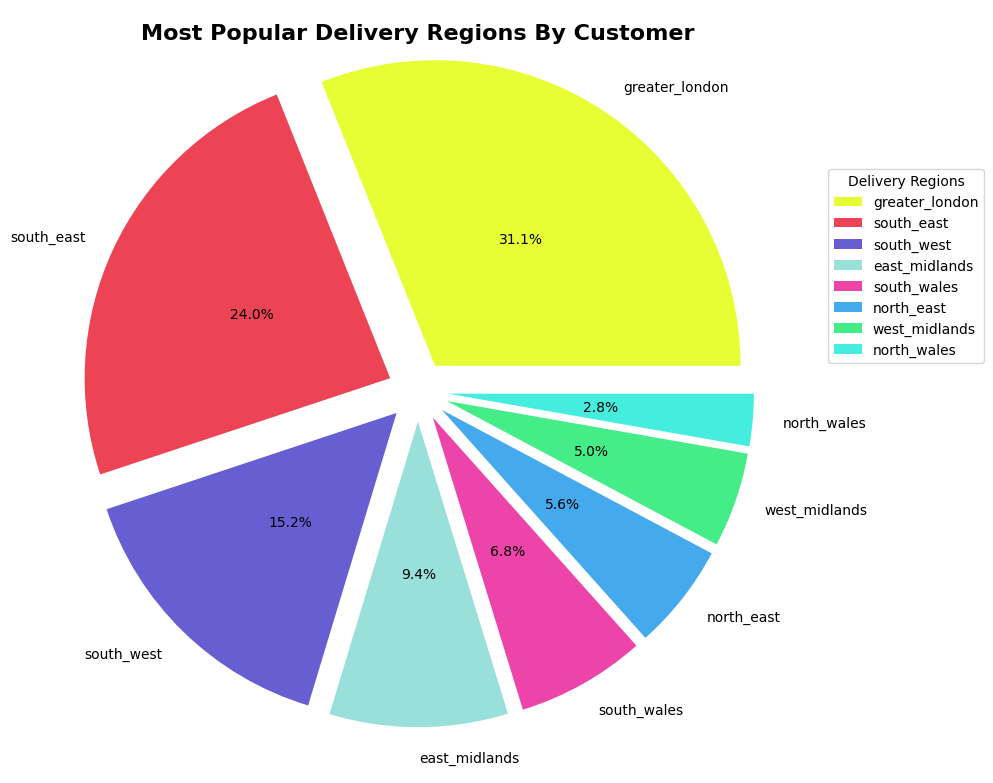

Here we can see that the most popular delivery region by customer is Greater London with 31.5% of orders being delivered here. Similar to most popular region by order, this gives reinforced reassurance in making business decisions related to fleet, drivers, new depots.


In [33]:
# let's see this as a visualisation

plt.figure(figsize=(10, 10))

# choose favourite colours
colours = ['#E7FE34', '#ED4455', '#675ED2', '#99E0DB', '#ED44A9', '#44A9ED', '#44ED88', '#44EDDD']

plt.pie(most_popular_delivery_regions_by_customers['percentage_of_total_customers'], labels=most_popular_delivery_regions_by_customers['delivery_region'], colors=colours, autopct='%1.1f%%', pctdistance=0.5,
        explode=[0.1]*len(most_popular_delivery_regions_by_customers))

plt.title('Most Popular Delivery Regions By Customer', fontsize=16, fontweight='bold', ha='center', y=0.95)
plt.legend(title='Delivery Regions', loc='upper right', bbox_to_anchor=(1.25, 0.8))

plt.tight_layout()
plt.savefig('/Users/lottiejanepollare/Library/Mobile Documents/com~apple~CloudDocs/CV, Profiles, Interviews & Job Applications/applications/techmodal_analyst_data_engineer/20230825_Analyst_case_study_submission_Lottie_Jane_Pollard/images/data_visualisations/fig6_most_popular_delivery_regions_by_customer.png')

plt.show()

print(f"Here we can see that the most popular delivery region by customer is Greater London with 31.5% of orders being delivered here. Similar to most popular region by order, this gives reinforced reassurance in making business decisions related to fleet, drivers, new depots.")

# SOLVING THE PROBLEM - Let's look at how to figure out how many trucks Mr. Haulage may need...

### First, let's aggregate the historical boxes ordered each day
### then, let's only take the most recent data for a full year - which would be March 2022 - March 2023 - This would be the most reliable data to base our decision on

In [16]:
# filter the data to only include the records from 2022-03-01 to 2023-03-31
latest_full_year_data = mr_haulage_df[(mr_haulage_df['order_date'] >= '2022-03-01') & (mr_haulage_df['order_date'] <= '2023-03-31')]

# first, let's look at the historical daily demand for each box size per region
estimated_daily_demand = latest_full_year_data.groupby(['order_date', 'delivery_region', 'box_type']).size().reset_index(name='box_count')

# Filter out rows where count is 0
estimated_daily_demand = estimated_daily_demand[estimated_daily_demand['box_count'] > 0]

estimated_daily_demand

,order_date,delivery_region,box_type,box_count
2,2022-03-01,greater_london,large,1
9,2022-03-01,south_east,small,1
11,2022-03-01,south_wales,small,1
12,2022-03-01,south_west,large,1
13,2022-03-01,south_west,small,1
...,...,...,...,...
6297,2023-03-29,south_east,small,1
6307,2023-03-30,greater_london,small,2
6312,2023-03-30,south_east,large,1
6333,2023-03-31,south_west,small,1


# OPTION 1 - PRIORITISING LARGE TRUCKS TO ALLOW FOR GROWTH
## by opting to purchase large trucks instead of small (in cases where you have surplus 1,2,3 small boxes - not enough to fill a large truck) you are allowing for growth of an extra small box & giving yourself the flexibility to utilise the same vehicle for large or small boxes)

In [17]:
# let's copy the estimated daily demand for boxes & use it to calculate OPTION 1
daily_demand_op_1 = estimated_daily_demand.copy()

### Let's create a dataframe showing how many trucks are needed for the number of boxes on each day

In [18]:
# initialise an empty list to store aggregated records
aggregated_data_daily_op_1 = []

# loop through each unique combination of delivery_region and order_date
for (region, date) in daily_demand_op_1.groupby(['delivery_region', 'order_date']).groups.keys():
    region_date_data_op_1 = daily_demand_op_1[(daily_demand_op_1['delivery_region'] == region) & (daily_demand_op_1['order_date'] == date)]

    # initialise counters for trucks
    daily_small_trucks_op_1 = 0
    daily_large_trucks_op_1 = 0

    # calculate number of small trucks needed
    if 'small' in region_date_data_op_1['box_type'].values:
        daily_small_box_count_op_1 = region_date_data_op_1.loc[region_date_data_op_1['box_type'] == 'small', 'box_count'].values[0]

        # convert sets of 4 small boxes to a large truck
        daily_large_trucks_op_1 += daily_small_box_count_op_1 // 4
        remaining_small_boxes_op_1 = daily_small_box_count_op_1 % 4

        # if there are 3 remaining small boxes, use a large truck
        if remaining_small_boxes_op_1 == 3:
            daily_large_trucks_op_1 += 1
        # if there are 2 remaining small boxes, use two small trucks
        if remaining_small_boxes_op_1 == 2:
            daily_small_trucks_op_1 += 2
        # if there is 1 remaining small box, use a small truck
        elif remaining_small_boxes_op_1 == 1:
            daily_small_trucks_op_1 += 1

    # calculate number of large trucks needed
    if 'large' in region_date_data_op_1['box_type'].values:
        daily_large_box_count_op_1 = region_date_data_op_1.loc[region_date_data_op_1['box_type'] == 'large', 'box_count'].values[0]
        daily_large_trucks_op_1 += daily_large_box_count_op_1

    # append to initialised list
    aggregated_data_daily_op_1.append([date, region, daily_small_trucks_op_1, daily_large_trucks_op_1])

# convert list to dataframe
aggregated_df_daily_op_1 = pd.DataFrame(aggregated_data_daily_op_1, columns=['order_date', 'delivery_region', 'daily_small_trucks_needed', 'daily_large_trucks_needed'])
aggregated_df_daily_op_1 = aggregated_df_daily_op_1.sort_values(by='order_date', ascending=True)

aggregated_df_daily_op_1

,order_date,delivery_region,daily_small_trucks_needed,daily_large_trucks_needed
837,2022-03-01,south_west,1,1
493,2022-03-01,south_east,1,0
742,2022-03-01,south_wales,1,0
122,2022-03-01,greater_london,0,1
1004,2022-03-01,west_midlands,1,0
...,...,...,...,...
121,2023-03-29,east_midlands,1,0
741,2023-03-30,south_east,0,1
393,2023-03-30,greater_london,2,0
1003,2023-03-31,south_west,1,0


In [19]:
# let's aggregate the count by date
aggregated_df_grouped_op_1 = aggregated_df_daily_op_1.groupby('order_date').agg({'daily_small_trucks_needed': 'sum', 'daily_large_trucks_needed': 'sum'}).reset_index()
aggregated_df_grouped_op_1

,order_date,daily_small_trucks_needed,daily_large_trucks_needed
0,2022-03-01,4,2
1,2022-03-02,3,1
2,2022-03-03,3,1
3,2022-03-04,4,1
4,2022-03-05,2,2
...,...,...,...
391,2023-03-27,1,1
392,2023-03-28,4,0
393,2023-03-29,2,0
394,2023-03-30,2,1


In [20]:
# now, to see the maximum, we'd need to service the contract efficiently
max_small_trucks_op_1 = aggregated_df_grouped_op_1['daily_small_trucks_needed'].max()
max_large_trucks_op_1 = aggregated_df_grouped_op_1['daily_large_trucks_needed'].max()

print(f"The total number of Small Trucks to purchase based on the historical dataset provided is: {max_small_trucks_op_1}.")
print(f"--------------------------------------------------------")
print(f"The total number of Large Trucks to purchase based on the historical dataset provided is: {max_large_trucks_op_1}.")
print(f"--------------------------------------------------------")

The total number of Small Trucks to purchase based on the historical dataset provided is: 8.
--------------------------------------------------------
The total number of Large Trucks to purchase based on the historical dataset provided is: 5.
--------------------------------------------------------


# OPTION 2 - PRIORITISING SMALL TRUCKS TO MINIMISE CAPITAL EXPENDITURE
## changing the function to increment small trucks more over large trucks (3 small boxes = 3 small trucks) only opting to increment by large truck when capacity (4 small boxes) is reached

In [21]:
# let's copy the estimated daily demand to calculate for OPTION 2
daily_demand_op_2 = estimated_daily_demand.copy()

In [22]:
# initialise empty list to store aggregated records
aggregated_data_daily_op_2 = []

# loop through each unique combination of delivery_region and order_date
for (region, date) in daily_demand_op_2.groupby(['delivery_region', 'order_date']).groups.keys():
    region_date_data_op_2 = daily_demand_op_2[(daily_demand_op_2['delivery_region'] == region) & (daily_demand_op_2['order_date'] == date)]

    # Initialise counter for trucks
    daily_small_trucks_op_2 = 0
    daily_large_trucks_op_2 = 0

    # calculate number of small trucks needed
    if 'small' in region_date_data_op_2['box_type'].values:
        daily_small_box_count_op_2 = region_date_data_op_2.loc[region_date_data_op_2['box_type'] == 'small', 'box_count'].values[0]

        # convert sets of 4 small boxes to a large truck
        daily_large_trucks_op_2 += daily_small_box_count_op_2 // 4
        remaining_small_boxes_op_2 = daily_small_box_count_op_2 % 4

        # if there are 1, 2, or 3 remaining small boxes, increment small trucks by that number
        if remaining_small_boxes_op_2 in [1, 2, 3]:
            daily_small_trucks_op_2 += remaining_small_boxes_op_2

    # calculate the number of large trucks needed
    if 'large' in region_date_data_op_2['box_type'].values:
        daily_large_box_count_op_2 = region_date_data_op_2.loc[region_date_data_op_2['box_type'] == 'large', 'box_count'].values[0]
        daily_large_trucks_op_2 += daily_large_box_count_op_2

    # append to initialised list
    aggregated_data_daily_op_2.append([date, region, daily_small_trucks_op_2, daily_large_trucks_op_2])

# convert list to dataframe
aggregated_df_daily_op_2 = pd.DataFrame(aggregated_data_daily_op_2, columns=['order_date', 'delivery_region', 'daily_small_trucks_needed', 'daily_large_trucks_needed'])
aggregated_df_daily_op_2 = aggregated_df_daily_op_2.sort_values(by='order_date', ascending=True)

aggregated_df_daily_op_2

,order_date,delivery_region,daily_small_trucks_needed,daily_large_trucks_needed
837,2022-03-01,south_west,1,1
493,2022-03-01,south_east,1,0
742,2022-03-01,south_wales,1,0
122,2022-03-01,greater_london,0,1
1004,2022-03-01,west_midlands,1,0
...,...,...,...,...
121,2023-03-29,east_midlands,1,0
741,2023-03-30,south_east,0,1
393,2023-03-30,greater_london,2,0
1003,2023-03-31,south_west,1,0


In [23]:
# let's aggregate the count by date
aggregated_df_grouped_op_2 = aggregated_df_daily_op_2.groupby('order_date').agg({'daily_small_trucks_needed': 'sum', 'daily_large_trucks_needed': 'sum'}).reset_index()
aggregated_df_grouped_op_2

,order_date,daily_small_trucks_needed,daily_large_trucks_needed
0,2022-03-01,4,2
1,2022-03-02,3,1
2,2022-03-03,3,1
3,2022-03-04,4,1
4,2022-03-05,2,2
...,...,...,...
391,2023-03-27,1,1
392,2023-03-28,4,0
393,2023-03-29,2,0
394,2023-03-30,2,1


In [24]:
# now, to see the maximum, we'd need to service the contract efficiently

max_small_trucks_op_2 = aggregated_df_grouped_op_2['daily_small_trucks_needed'].max()
max_large_trucks_op_2 = aggregated_df_grouped_op_2['daily_large_trucks_needed'].max()

print(f"The total number of Small Trucks to purchase based on the historical dataset provided is: {max_small_trucks_op_2}.")
print(f"--------------------------------------------------------")
print(f"The total number of Large Trucks to purchase based on the historical dataset provided is: {max_large_trucks_op_2}.")
print(f"--------------------------------------------------------")

The total number of Small Trucks to purchase based on the historical dataset provided is: 8.
--------------------------------------------------------
The total number of Large Trucks to purchase based on the historical dataset provided is: 5.
--------------------------------------------------------


## Interestingly, both options return the same figures as the max of trucks needed daily is the same for both scenarios. We could check the 'mean' but I think this will cause a deficit

### Let's just attempt a MEAN Calculation - Let's check the figures if we take the average (mean) trucks needed...

In [25]:
mean_trucks_check = aggregated_df_grouped_op_2.copy()

In [26]:
# filter out rows where count is 0 so as not to skew the mean
mean_trucks_check = mean_trucks_check[mean_trucks_check['daily_small_trucks_needed'] > 0]
mean_trucks_check = mean_trucks_check[mean_trucks_check['daily_large_trucks_needed'] > 0]

# take the average trucks needed per day after removing days when 0 were needed
avg_small_trucks_needed_mean = math.ceil(mean_trucks_check['daily_small_trucks_needed'].mean())
avg_large_trucks_needed_mean = math.ceil(mean_trucks_check['daily_large_trucks_needed'].mean())

print(f"The total number of Small Trucks to purchase based on the historical dataset provided is: {avg_small_trucks_needed_mean}.")
print(f"--------------------------------------------------------")
print(f"The total number of Large Trucks to purchase based on the historical dataset provided is: {avg_small_trucks_needed_mean}.")
print(f"--------------------------------------------------------")

The total number of Small Trucks to purchase based on the historical dataset provided is: 3.
--------------------------------------------------------
The total number of Large Trucks to purchase based on the historical dataset provided is: 3.
--------------------------------------------------------


## As predicted, the average would be 3 large & 3 small trucks but we couldn't fulfil orders on days when more than 3 were placed. I conclude that using MEAN calculations wouldn't work as there would be a huge deficit on the days when more orders were placed.

# OPTION 3 - SMALL TRUCKS DOING MORE TRIPS IN GREATER LONDON
### Given the average distance for deliveries in Greater London being 26.91 miles one-way (approximately 30 minutes), so one hour round trip, with one hour loading time per delivery, a driver should be able to reload a small van approximately 3 times per working day easily (6 hours total) for deliveries in Greater London only. The expenditure you currently pay is a daily rate per driver & a daily rate per fuel, so you should maximise on your assets if possible. This would bring the number of small trucks needed down by 2 saving £4,000

In [27]:
daily_demand_op_3 = estimated_daily_demand.copy()

# Modify the function to consider that each small truck in the region of Greater London can only deliver 3 boxes
aggregated_data_daily_op_3 = []

# Loop through each unique combination of delivery_region and order_date
for (region, date) in daily_demand_op_3.groupby(['delivery_region', 'order_date']).groups.keys():
    region_date_data_op_3 = daily_demand_op_3[(daily_demand_op_3['delivery_region'] == region) & (daily_demand_op_3['order_date'] == date)]

    # Initialise counters for trucks
    daily_small_trucks_op_3 = 0
    daily_large_trucks_op_3 = 0

    # Calculate number of small trucks needed
    if 'small' in region_date_data_op_3['box_type'].values:
        daily_small_box_count_op_3 = region_date_data_op_3.loc[region_date_data_op_3['box_type'] == 'small', 'box_count'].values[0]

        # Special case for Greater London: each small truck can only deliver 3 boxes
        if region == 'greater_london':
            daily_small_trucks_op_3 += daily_small_box_count_op_3 // 3
            remaining_small_boxes_op_3 = daily_small_box_count_op_3 % 3
        else:
            # Convert sets of 4 small boxes to a large truck for other regions
            daily_large_trucks_op_3 += daily_small_box_count_op_3 // 4
            remaining_small_boxes_op_3 = daily_small_box_count_op_3 % 4

        # Additional conditions based on remaining small boxes
        if remaining_small_boxes_op_3 >= 1:
            daily_small_trucks_op_3 += 1

    # Calculate number of large trucks needed
    if 'large' in region_date_data_op_3['box_type'].values:
        daily_large_box_count_op_3 = region_date_data_op_3.loc[region_date_data_op_3['box_type'] == 'large', 'box_count'].values[0]
        daily_large_trucks_op_3 += daily_large_box_count_op_3

    # Append to initialised list
    aggregated_data_daily_op_3.append([date, region, daily_small_trucks_op_3, daily_large_trucks_op_3])

# Convert list to DataFrame and sort by order_date
aggregated_df_daily_op_3 = pd.DataFrame(aggregated_data_daily_op_3, columns=['order_date', 'delivery_region', 'daily_small_trucks_needed', 'daily_large_trucks_needed'])
aggregated_df_daily_op_3 = aggregated_df_daily_op_3.sort_values(by='order_date', ascending=True)

# Display the modified DataFrame
aggregated_df_daily_op_3

,order_date,delivery_region,daily_small_trucks_needed,daily_large_trucks_needed
837,2022-03-01,south_west,1,1
493,2022-03-01,south_east,1,0
742,2022-03-01,south_wales,1,0
122,2022-03-01,greater_london,0,1
1004,2022-03-01,west_midlands,1,0
...,...,...,...,...
121,2023-03-29,east_midlands,1,0
741,2023-03-30,south_east,0,1
393,2023-03-30,greater_london,1,0
1003,2023-03-31,south_west,1,0


In [28]:
# let's aggregate the count by date
aggregated_df_grouped_op_3 = aggregated_df_daily_op_3.groupby('order_date').agg({'daily_small_trucks_needed': 'sum', 'daily_large_trucks_needed': 'sum'}).reset_index()
aggregated_df_grouped_op_3

,order_date,daily_small_trucks_needed,daily_large_trucks_needed
0,2022-03-01,4,2
1,2022-03-02,2,1
2,2022-03-03,2,1
3,2022-03-04,3,1
4,2022-03-05,2,2
...,...,...,...
391,2023-03-27,1,1
392,2023-03-28,4,0
393,2023-03-29,2,0
394,2023-03-30,1,1


In [29]:
# now, to see the maximum, we'd need to service the contract efficiently

max_small_trucks_op_2 = aggregated_df_grouped_op_3['daily_small_trucks_needed'].max()
max_large_trucks_op_2 = aggregated_df_grouped_op_3['daily_large_trucks_needed'].max()

print(f"The total number of Small Trucks to purchase based on the historical dataset provided is: {max_small_trucks_op_2}.")
print(f"--------------------------------------------------------")
print(f"The total number of Large Trucks to purchase based on the historical dataset provided is: {max_large_trucks_op_2}.")
print(f"--------------------------------------------------------")

The total number of Small Trucks to purchase based on the historical dataset provided is: 6.
--------------------------------------------------------
The total number of Large Trucks to purchase based on the historical dataset provided is: 5.
--------------------------------------------------------


# CONCLUSION:

In [30]:
# read through all the notes I've got printed off
# go through other interview areas

# graph for orders over 1 year
# change the logo spelling mistake
# check the word defence everywhere
# conclusion

# run the sql script
# put the presentation together
# letter / report to Mr Haulage
    # - present actionable recommendations - easy to list format
# git & github
# email to Techmodal

# Complete report for Mr Haulage
# advise our logistics software - expend once to receive return on all deliveries forever

# THEN CREATE A COST ANALYSIS NOTEBOOK